# Transferencia de aprendizaje de InceptionV3 para el dataset RPC 

En el presente notebook, se realiza $\textbf{Transfer Learning}$ con el modelo InceptionV3, el cual fue pre-entrenado con el Dataset $\textbf{Imagenet}$, para realizar tareas de clasificación con las 17 super categorías del dataset $\textbf{Retail Product Checkout Dataset (RPC)}$. En el proceso, la idea es utilizar InceptionV3 como extractor de características para facilitar la tarea de clasificación. El notebook tiene dos etapas: $\textbf{Entrenamiento sin modificación de los pesos de InceptionV3}$ y $\textbf{Fine-Tuning}$ de algunas de las capas.

## Contenido

#### 1. Actividades preliminares
#### 2. Carga del modelo InceptionV3
#### 3. Entrenamiento del modelo sin modificar los pesos de InceptionV3
#### 4. Fine - Tuning en InceptionV3



## 1. Actividades preliminares

A continuación, se importan las librerías que se utilizarán en el notebook. 

In [1]:
#Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#Funciones de librerias para el procesamiento de imágenes
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


En la siguiente celda, se lee el archivo que contiene la información de las imágenes y se crea un dataframe con los datos.

In [58]:
data_df = pd.read_json('./data/instances_train2019.json', lines=True)
categories = data_df['categories'][0]
categories = df = pd.DataFrame.from_dict(categories, orient='columns')
annotations = data_df['annotations'][0]
annotations = df = pd.DataFrame.from_dict(annotations, orient='columns')
images = data_df['images'][0]
images = df = pd.DataFrame.from_dict(images, orient='columns')

annot_x_categ = pd.merge(annotations, categories, how='left', left_on=['category_id'], right_on=['id'])
y_names = annot_x_categ['supercategory'].unique().tolist()
annot_x_categ_file_names = pd.merge(annot_x_categ, images, how='left', left_on=['image_id'], right_on=['id'])
y_data = np.array(annot_x_categ_file_names['supercategory'].values)
X_data = np.array(annot_x_categ_file_names['file_name'].values)
num_classes = len(y_names)

X_data.shape, y_data.shape, num_classes

((53739,), (53739,), 17)

Se definen dos funciones que nos servirán para ver graficamente los resultados del entrenamiento. En la primera, el parámentro de entrada es un modelo recién entrenado, y en la segunda, la entrada puede ser una lista que contenga los valores de las métricas en cada época. Ambas funciones realizan un gráfico de $\textbf{accuracy}$ y $\textbf{accuracy_validation}$ contra $\textbf{épocas}$ y otro de $\textbf{loss}$ y $\textbf{loss_validation}$ contra las $\textbf{épocas}$.

In [35]:
def plot_metrics_model(model):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(model.history.history["acc"], label="acc")
    plt.plot(model.history.history["val_acc"], label="val_acc")
    plt.grid()
    plt.legend();
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.ylim(0,1.05)
    
    plt.subplot(1,2,2)
    loss  = model.history.history["loss"]
    vloss = model.history.history["val_loss"]
    plt.plot(loss, lw=4, alpha=.5, label="loss")
    plt.plot(vloss, lw=4, alpha=.5, label="val loss")
    plt.grid();
    plt.legend();
    
    plt.show()

In [53]:
def plot_metrics(acc,val_acc,loss,val_loss):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label="acc")
    plt.plot(val_acc, label="val_acc")
    plt.grid()
    plt.legend();
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.ylim(0,1.05)

    plt.subplot(1,2,2)
    plt.plot(loss, lw=4, alpha=.5, label="loss")
    plt.plot(val_loss, lw=4, alpha=.5, label="val loss")
    plt.grid();
    plt.legend();

    plt.show()

Se divide el conjunto de datos entre train y test, y se crea un dataframe para cada conjunto de datos:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45678,), (8061,), (45678,), (8061,))

In [11]:
columns = ['filename','class']

df_train = pd.DataFrame(columns=columns)
df_train['filename'] = X_train.astype(str)
df_train['class'] = y_train.astype(str)

df_test = pd.DataFrame(columns=columns)
df_test['filename'] = X_test.astype(str)
df_test['class'] = y_test.astype(str)

Luego de esto, se utiliza $\textbf{ImageDataGenerator}$ para normalizar las imágenes y realizar un split de las imágenes del train, dejando un 20% para validación. Se define un tamaño de batch de 50 imágenes y un tamaño de imágen de 200x200. Finalmente, se definen las funciones con las cuales se cargarán las imágenes por lotes para train, validation y test.

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest', validation_split=0.2)
batch_size = 50
img_size = 200

train_generator_fn = lambda: train_datagen.flow_from_dataframe(
        df_train,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        subset="training",
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

valid_generator_fn = lambda: train_datagen.flow_from_dataframe(
        df_train,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        subset="validation",
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

test_datagen=ImageDataGenerator(rescale=1./255, fill_mode='nearest')

test_generator_fn = lambda: test_datagen.flow_from_dataframe(
        df_test,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

## 2. Carga del modelo InceptionV3 

Cargamos el modelo InceptionV3, incluyendo los $\textbf{pesos}$, y excluyendo las capas de la parte superior, es decir,  las capas densas y la de clasificación.

In [5]:
from keras.applications import inception_v3
inception_model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

Using TensorFlow backend.


Se aplica la función GlobalAveragePooling2D como paso previo a la entrada de las imágenes a una capa densa. Luego de esto, se crea una capa densa de 1024 neuronas y, finalmente, se crea la capa de salida con 17 neuronas. 

El procedimiento que se sigue a continuación, se realiza con la ayuda de uno de los ejemplos de [este link.](https://keras.io/applications/)

In [6]:
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(17, activation='softmax')(x)

Se crea un modelo que incluye las capas agregadas en la celda anterior.

In [7]:
model = Model(inputs=inception_model.input,outputs = predictions)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, None, None, 7 0           mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, None, None, 1 147456      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 1 215040      activation_43[0][0]              
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, None, None, 1 215040      activation_48[0][0]              
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, None, None, 1 147456      average_pooling2d_5[0][0]        
__________

## 3. Entrenamiento del modelo sin modificar los pesos de InceptionV3

En este punto, se "congelan" los pesos de las capas importadas de InceptionV3. En otras palabras, estas capas quedarán como no entrenables: 

In [9]:
for layer in inception_model.layers:
    layer.trainable = False

Se compila el modelo utilizando el optimizador $\textbf{Rmsprop}$, la función de pérdida $\textbf{Categorical Crossentropy}$, y definiendo la métrica $\textbf{accuracy}$. Esto debe hacerse luego de haber configurado las capas no entrenables.

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])

A continuación, se realiza el entrenamiento del modelo con 30 épocas y 20 pasos por época. 

In [13]:
model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=30,
        validation_data=valid_generator_fn(),
        validation_steps=400 // batch_size)

Found 36543 images belonging to 17 classes.
Found 9135 images belonging to 17 classes.
Epoch 1/30
20/20 [==============================] - 591s 30s/step - loss: 5.1994 - acc: 0.1410 - val_loss: 3.4227 - val_acc: 0.1925
Epoch 2/30
20/20 [==============================] - 556s 28s/step - loss: 2.6086 - acc: 0.1980 - val_loss: 2.9901 - val_acc: 0.2600
Epoch 3/30
20/20 [==============================] - 540s 27s/step - loss: 2.2765 - acc: 0.2770 - val_loss: 2.9848 - val_acc: 0.2475
Epoch 4/30
20/20 [==============================] - 561s 28s/step - loss: 2.1620 - acc: 0.3260 - val_loss: 3.1267 - val_acc: 0.1900
Epoch 5/30
20/20 [==============================] - 544s 27s/step - loss: 1.9110 - acc: 0.4020 - val_loss: 4.7363 - val_acc: 0.1450
Epoch 6/30
20/20 [==============================] - 524s 26s/step - loss: 1.7799 - acc: 0.4200 - val_loss: 3.8680 - val_acc: 0.2200
Epoch 7/30
20/20 [==============================] - 501s 25s/step - loss: 1.8286 - acc: 0.4220 - val_loss: 4.5844 - val_a

In [54]:
loss_train1=[5.1994, 2.6086, 2.2765, 2.1620, 1.9110, 1.7799, 1.8286, 1.6784, 1.6009, 1.7045, 1.4977, 1.5333, 1.4564, 1.3207, 1.3251, 1.2955, 1.2739, 1.1919, 1.1572, 1.2121, 1.1217, 1.2464, 1.2201, 1.0365, 1.0631, 1.1615, 0.9956, 1.0292, 1.0016, 0.9488]
val_loss_train1=[3.4227, 2.9901, 2.9848, 3.1267, 4.7363, 3.8680, 4.5844, 3.7536, 4.5043, 3.5003, 3.7132, 4.1132, 3.3891, 3.6490, 4.6717, 4.2952, 3.7282, 3.6831, 3.3956, 3.4834, 3.2536, 3.9471, 3.1981, 3.6210, 3.3306, 4.5006, 3.6573, 4.0867, 2.7582, 4.1294]
acc_train1=[0.1410, 0.1980, 0.2770, 0.3260, 0.4020, 0.4200, 0.4220, 0.4620, 0.4550, 0.4660, 0.5010, 0.5070, 0.5190, 0.5520, 0.5640, 0.5820, 0.5880, 0.5770, 0.6050, 0.6110, 0.6200, 0.5980, 0.5840, 0.6540, 0.6320, 0.6370, 0.6740, 0.6440, 0.6770, 0.6860]
val_acc_train1=[0.1925, 0.2600, 0.2475, 0.1900, 0.1450, 0.2200, 0.1550, 0.2000, 0.1350, 0.2175, 0.2275, 0.2175, 0.25, 0.2625, 0.2225, 0.2375, 0.2450, 0.2625, 0.3275, 0.2900, 0.3225, 0.2925,0.3091, 0.3325, 0.2825, 0.2475, 0.2750, 0.2550, 0.3700,0.2725] 
print len(loss_train1), len(val_loss_train1), len(acc_train1), len(val_acc_train1)

30 30 30 30


El comportamiento de las métricas de precisión (acc), validación de la precisión (val_acc), función de pérdida (loss) y validación de la pérdida (val_loss), puede observarse a continuación:

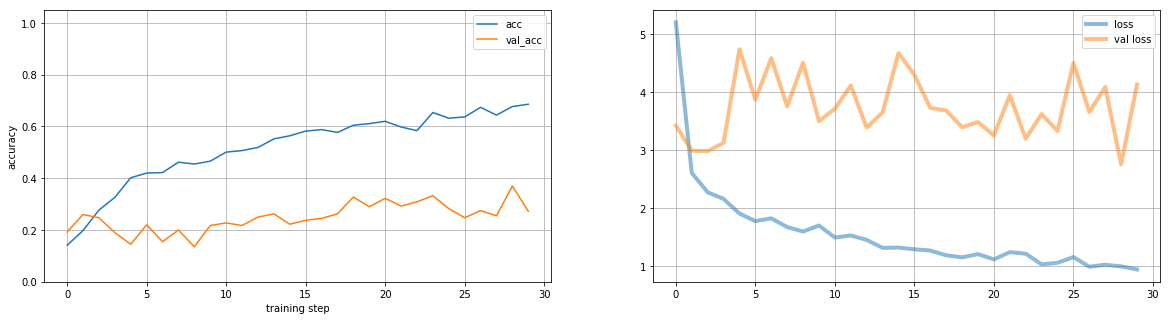

In [55]:
plot_metrics(acc_train1,val_acc_train1,loss_train1,val_loss_train1)

En la gráfica de la izquieda, se observa que la precisión del entrenamiento aumenta conforme se incrementa el número de épocas, mientras que la validación de la precisión no logra superar el 40%. 

Por su parte, la pérdida disminuye de forma progresiva, mientras que la validación de la pérdida presenta un comportamiento oscilatorio, sin mostrar una tendencia.

## 4. Fine - Tuning en InceptionV3

Luego de haber entrenado bien las capas superiores que se crearon en la sección 2, se procede a realizar Fine-Tuning en las capas convolucionales de InceptionV3.

A continuación, es posible visualizar los índices de las capas de la red importada para seleccionar las capas a "descongelar":

In [15]:
for i, layer in enumerate(inception_model.layers):
   print(i, layer.name)

(0, 'input_1')
(1, 'conv2d_1')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_2')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_3')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_1')
(11, 'conv2d_4')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_5')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_2')
(18, 'conv2d_9')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_7')
(22, 'conv2d_10')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_6')
(29, 'conv2d_8')
(30, 'conv2d_11')
(31, 'conv2d_12')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_16')
(42, 'batch_normalization_16')
(43, 'activation_16')
(44, 'c

En la siguiente celda, se congelan las primeras 249 capas y se descongela el resto:

In [16]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

Nuevamente se compila el modelo para que los cambios se tengan en cuenta en el entrenamiento. Esta vez, para el entrenamiento se utiliza el optimizador $\textbf{Stochastic gradient descent (SGD)}$.

In [19]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])

In [20]:
model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=30,
        validation_data=valid_generator_fn(),
        validation_steps=400 // batch_size)

Found 36543 images belonging to 17 classes.
Found 9135 images belonging to 17 classes.
Epoch 1/30
20/20 [==============================] - 580s 29s/step - loss: 0.7783 - acc: 0.7290 - val_loss: 3.4175 - val_acc: 0.3200
Epoch 2/30
20/20 [==============================] - 503s 25s/step - loss: 0.7589 - acc: 0.7360 - val_loss: 3.4796 - val_acc: 0.3175
Epoch 3/30
20/20 [==============================] - 470s 24s/step - loss: 0.7054 - acc: 0.7750 - val_loss: 3.1202 - val_acc: 0.3650
Epoch 4/30
20/20 [==============================] - 491s 25s/step - loss: 0.6475 - acc: 0.7920 - val_loss: 2.9232 - val_acc: 0.4000
Epoch 5/30
20/20 [==============================] - 523s 26s/step - loss: 0.6581 - acc: 0.7790 - val_loss: 2.9406 - val_acc: 0.3575
Epoch 6/30
20/20 [==============================] - 539s 27s/step - loss: 0.6907 - acc: 0.7620 - val_loss: 3.0350 - val_acc: 0.3150
Epoch 7/30
20/20 [==============================] - 543s 27s/step - loss: 0.6062 - acc: 0.7890 - val_loss: 2.8775 - val_a

A continuación, se observa el comportamiento de las métricas en el entrenamiento del modelo:

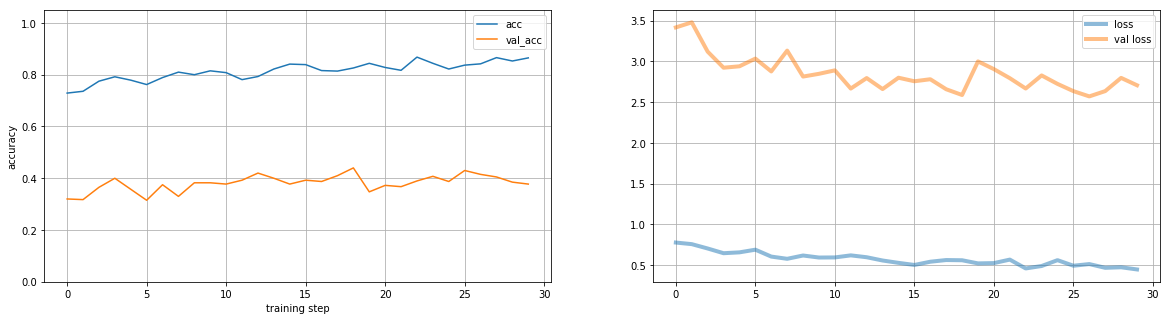

In [36]:
plot_acc(model)

Como podemos observar, la precisión siguie incrementandose hasta alcanzar un valor final del 86.5%, mientras que la validación de precisión apenas logra superar el 40% en algunas épocas, terminando con un valor de 37.35%. Por su parte, la pérdida sigue decreciendo, mientras que la validación de la pérdida empieza a estabilizarse.

A continuación, se relizarán las gráficas teniendo en cuenta los valores de las métricas desde el primer entrenamiento.

In [51]:
acc_train2 = model.history.history["acc"]
val_acc_train2 = model.history.history["val_acc"]
loss_train2  = model.history.history["loss"]
val_loss_train2 = model.history.history["val_loss"]
acc_train_acum = acc_train1+acc_train2
val_acc_train_acum = val_acc_train1 + val_acc_train2
loss_train_acum = loss_train1 + loss_train2
val_loss_train_acum = val_loss_train1 + val_loss_train2

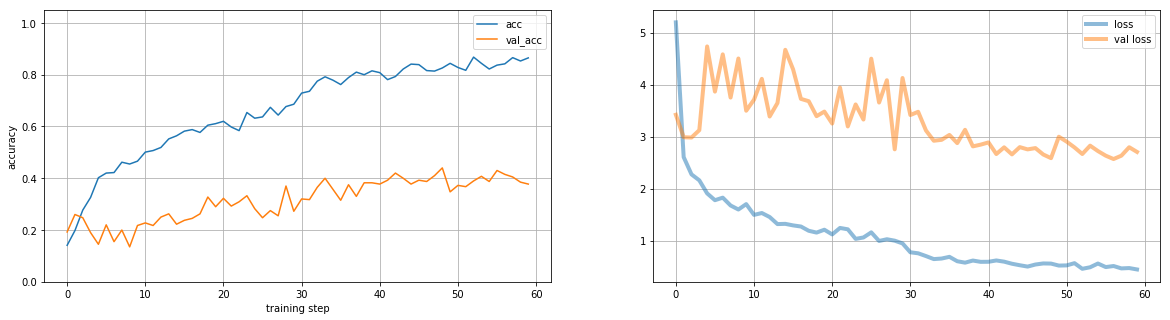

In [56]:
plot_metrics(acc_train_acum,val_acc_train_acum,loss_train_acum,val_loss_train_acum )

En general, se observa que la precisión sigue aumentando de forma progresiva conforme avanzan las épocas. La validación de la pérdida, aunque más lentamente, también aumenta. Con respecto a los valores finales, se observa que existe una diferencia de 48.75%, lo que nos permite tener serios indicios sobre la existencia de overfitting en este modelo.

Con respecto a la pérdida, observamos que sigue disminuyendo, mientras que la validación de perdida empieza a mostrar un comportamiento cada vez más estable.

A continuación, se guardan los resultados del entrenamiento realizado:

In [57]:
model.save("Transfer_Learning_InceptionV3.model")